P/N: NTCG103JX103DT1
B25/85: 3435K +-0.7%
R: 10K +- 0.5%
[Product Page](https://product.tdk.com/en/search/sensor/ntc/chip-ntc-thermistor/info?part_no=NTCG103JX103DT1&utm_medium=catalog&utm_source=tpd_commercial_ntc-thermistor_ntcg_en.pdf)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, fsolve
from FixedPoint import FXfamily, FXnum

In [2]:
CELSIUS_TO_KELVIN = 273.15

# ------------------------------
# Utility: Steinhart-Hart Model
# ------------------------------

def steinhart_hart_lnR(R: float, A: float, B: float, C: float) -> float:
    lnR = np.log(R)
    return A + B * lnR + C * lnR**3

def fit_steinhart_hart(resistances_ohms, temps_celsius, p0=None):
    """Fit Steinhart-Hart model to resistance and temperature data."""
    temps_kelvin = np.array(temps_celsius) + CELSIUS_TO_KELVIN
    inv_temps = 1.0 / temps_kelvin
    resistances = np.array(resistances_ohms)

    p0 = p0 or [1.0e-3, 2.0e-4, 1.0e-7]  # reasonable guess
    popt, _ = curve_fit(steinhart_hart_lnR, resistances, inv_temps, p0=p0, maxfev=100000, check_finite=False)
    return tuple(popt)  # A, B, C


# ------------------------------
# Utility: Beta Model
# ------------------------------

def beta_model(R, B, T1=25 + CELSIUS_TO_KELVIN, R1=10e3):
    return T1 / (1 - T1 * np.log(R1 / R) / B)

def fit_beta_model(resistances_ohms, temps_celsius, p0=None):
    """Fit beta model to resistance and temperature data."""
    temps_kelvin = np.array(temps_celsius) + CELSIUS_TO_KELVIN
    p0 = p0 or [3500.0]
    popt, _ = curve_fit(beta_model, resistances_ohms, temps_kelvin, p0=p0, maxfev=100000, check_finite=False)
    return popt[0]


# ------------------------------
# Steinhart-Hart Thermistor Class
# ------------------------------

class Thermistor:
    def __init__(self, A: float, B: float, C: float, R0: float = 10_000):
        self.A = A
        self.B = B
        self.C = C
        self.R0 = R0

    def resistance_to_kelvin(self, R: float) -> float:
        inv_T = steinhart_hart_lnR(R, self.A, self.B, self.C)
        return 1.0 / inv_T

    def resistance_to_celsius(self, R: float) -> float:
        return self.resistance_to_kelvin(R) - CELSIUS_TO_KELVIN

    def celsius_to_resistance(self, T_C: float) -> float:
        T_K = T_C + CELSIUS_TO_KELVIN
        return self.kelvin_to_resistance(T_K)

    def kelvin_to_resistance(self, T_K: float) -> float:
        def f(R): return self.resistance_to_kelvin(R) - T_K
        R_guess = np.exp(1/T_K - self.A)/self.B * 0.25
        R_solution, = fsolve(f, R_guess, maxfev=100000)
        return R_solution

# ------------------------------
# Beta Model Thermistor Class
# ------------------------------

class ThermistorBetaModel:
    def __init__(self, B: float, R1: float = 10_000, T1: float = 25 + CELSIUS_TO_KELVIN):
        self.B = B
        self.R1 = R1
        self.T1 = T1

    @staticmethod
    def calc_B(R1, R2, T1, T2):
        return T1 * T2 / (T2 - T1) * np.log(R1 / R2)

    def kelvin_to_resistance(self, T_K: float) -> float:
        exponent = self.B * (T_K - self.T1) / (self.T1 * T_K)
        return self.R1 * np.exp(exponent)

    def resistance_to_kelvin(self, R: float) -> float:
        return self.T1 / (1 - self.T1 * np.log(self.R1 / R) / self.B)

    def resistance_to_celsius(self, R: float) -> float:
        return self.resistance_to_kelvin(R) - CELSIUS_TO_KELVIN


# ------------------------------
# Load Data & Fit Models
# ------------------------------

df = pd.read_csv("./ntcg103jx103dt1.csv", skiprows=4)
resistances = df["Nom"] * 1e3  # Nominal resistance in ohms
temps_c = df["Temp"]           # Temperature in Celsius

# Steinhart-Hart Fit
A, B, C = fit_steinhart_hart(resistances, temps_c)
therm_sh = Thermistor(A, B, C)
print(f"Steinhart-Hart coefficients:\nA={A:.6e}, B={B:.6e}, C={C:.6e}")

# Beta Fit
B_val = fit_beta_model(resistances, temps_c)
therm_beta = ThermistorBetaModel(B_val, T1=25+CELSIUS_TO_KELVIN)
print(f"Beta model B value: {B_val:.2f}")
beta_fit = B_val

Steinhart-Hart coefficients:
A=8.794452e-04, B=2.525972e-04, C=1.897193e-07
Beta model B value: 3427.13


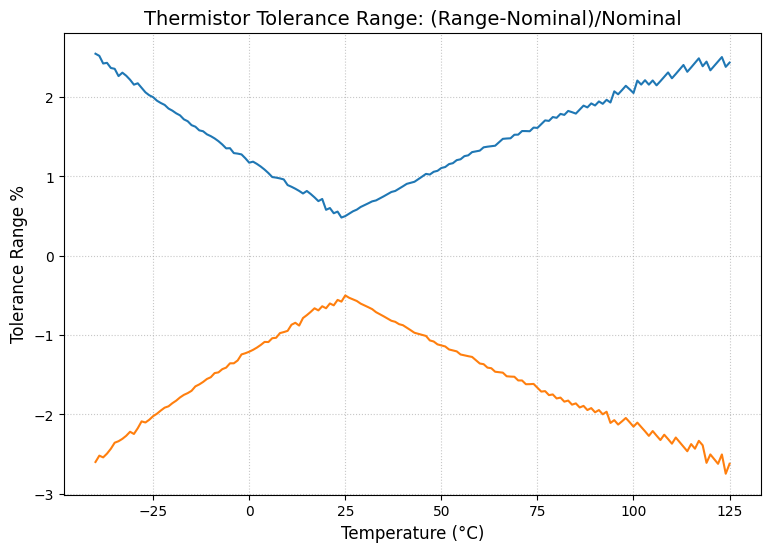

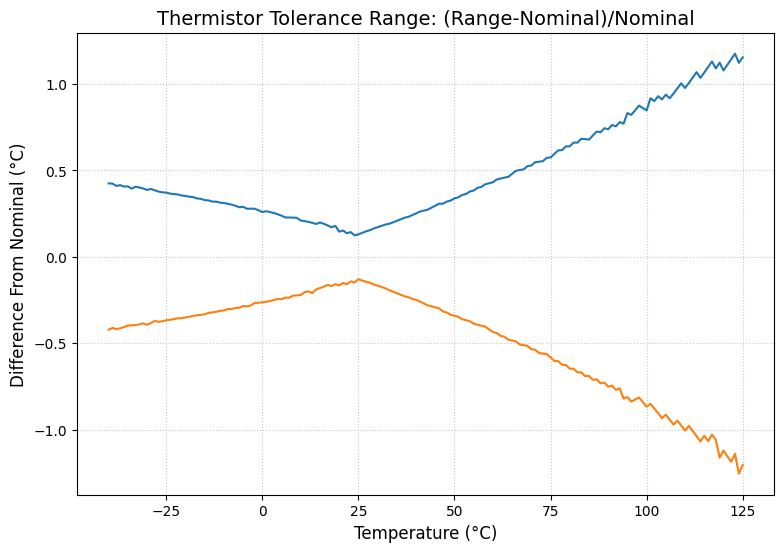

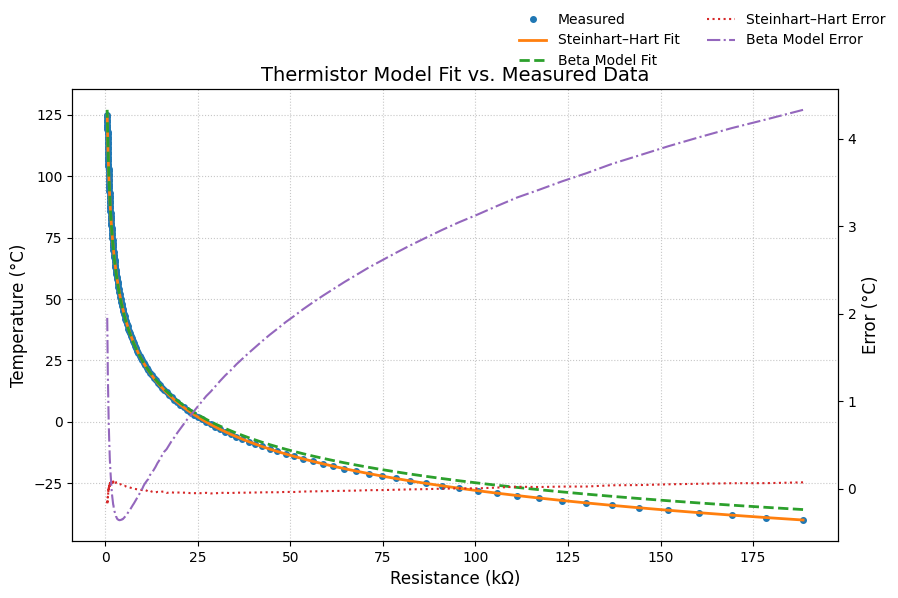

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assume: `df`, `res`, `therm`, `therm_2p`, `beta_fit` already defined
R = 10_000
tempk = df["Temp"] + CELSIUS_TO_KELVIN
tempc = df["Temp"]

res_kohm = resistances * 1e-3

fig, ax = plt.subplots(figsize=(9, 6))
therm_sh
ax.plot(tempc, (df["Nom"]-df["Min"])/df["Nom"]*100, label="Nominal-Min")
ax.plot(tempc, (df["Nom"]-df["Max"])/df["Nom"]*100, label="Nominal-Max")
ax.set_ylabel("Tolerance Range %", fontsize=12)
ax.set_xlabel("Temperature (°C)", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.set_title("Thermistor Tolerance Range: (Range-Nominal)/Nominal", fontsize=14)
fig.savefig("thermistor-tolerance-range-resistance.svg")
plt.show()

fig, ax = plt.subplots(figsize=(9, 6))
min_temp = therm_beta.resistance_to_kelvin(df["Min"]*1e3)
nom_temp = therm_beta.resistance_to_kelvin(df["Nom"]*1e3)
max_temp = therm_beta.resistance_to_kelvin(df["Max"]*1e3)

ax.plot(tempc, (min_temp-nom_temp), label="Nominal-Min")
ax.plot(tempc, (max_temp-nom_temp), label="Nominal-Min")
ax.set_ylabel("Difference From Nominal (°C)", fontsize=12)
ax.set_xlabel("Temperature (°C)", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.set_title("Thermistor Tolerance Range: (Range-Nominal)/Nominal", fontsize=14)
fig.savefig("thermistor-tolerance-range-temperature.svg")
plt.show()


def plot_temperature_fit():
    fig, ax = plt.subplots(figsize=(9, 6))

    # Fit curves
    ax.plot(res_kohm, tempc, 'o', label='Measured', markersize=4)
    ax.plot(res_kohm, therm_sh.resistance_to_celsius(resistances), label='Steinhart–Hart Fit', linewidth=2)
    ax.plot(res_kohm, therm_beta.resistance_to_celsius(resistances), label='Beta Model Fit', linestyle='--', linewidth=2)

    # Error (Secondary Axis)
    ax2 = ax.twinx()
    error_sh = therm_sh.resistance_to_kelvin(resistances) - tempk
    error_be = therm_beta.resistance_to_kelvin(resistances) - tempk

    ax2.plot(res_kohm, error_sh, label='Steinhart–Hart Error', color='tab:red', linestyle=':', linewidth=1.5)
    ax2.plot(res_kohm, error_be, label='Beta Model Error', color='tab:purple', linestyle='-.', linewidth=1.5)

    # Labels & Style
    ax.set_xlabel("Resistance (kΩ)", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    ax2.set_ylabel("Error (°C)", fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_title("Thermistor Model Fit vs. Measured Data", fontsize=14)

    # Combine Legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc="upper right", ncol=2, fontsize=10, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig("thermistor-models-fit-temperature.svg")
    plt.show()


# Run both plots
plot_temperature_fit()

In [4]:
def bisect_left(a, x):
    """
    Locate the insertion point for `x` in `a` to maintain sorted order.
    """
    lo = 0
    hi = len(a)
    while lo < hi:
        mid = (lo + hi) // 2
        if a[mid] < x:
            lo = mid + 1
        else:
            hi = mid
    return lo


def interpolate(x_vals, y_vals, x):
    """
    Linearly interpolate to find y for a given x, using x_vals and y_vals.
    """
    if not (len(x_vals) == len(y_vals) and len(x_vals) >= 2):
        raise ValueError("x_vals and y_vals must be the same length and contain at least 2 points")

    i = bisect_left(x_vals, x)

    # Clamp to edges
    if i == 0:
        return y_vals[0]
    if i == len(x_vals):
        return y_vals[-1]

    x0, x1 = x_vals[i - 1], x_vals[i]
    y0, y1 = y_vals[i - 1], y_vals[i]

    # Linear interpolation formula
    slope = (y1 - y0) / (x1 - x0)
    return y0 + slope * (x - x0)

In [5]:
family = FXfamily(n_bits=32, n_intbits=16)

x = np.linspace(100, 10000, (1<<12), dtype=int)
slow_log = np.log(x)

xlut = np.logspace(2, 8, 128)
lut = np.array([family(pt) for pt in np.log(xlut)])

lut_log = np.array([interpolate(xlut, lut, pt) for pt in x])
true_log = slow_log
approx_log = lut_log
error = (lut_log - true_log)/true_log

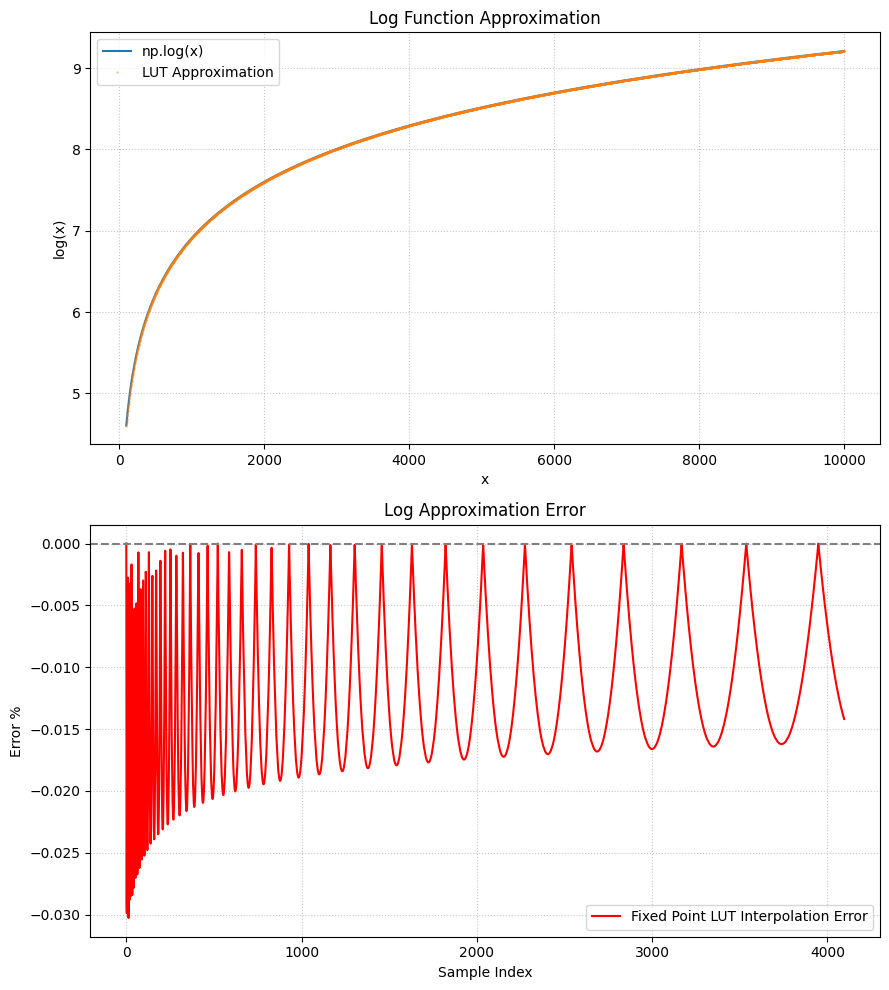

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(9, 10))

# --- Subplot 1: Error ---
axs[1].plot(error * 100, label='Fixed Point LUT Interpolation Error', color='red')
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_title("Log Approximation Error")
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel("Error %")
axs[1].grid(True, linestyle=':', alpha=0.7)
axs[1].legend()

# --- Subplot 2: Function Approximation ---
axs[0].plot(x, true_log, label='np.log(x)', linewidth=1.5)
axs[0].plot(x, approx_log, '.', label='LUT Approximation', markersize=1, alpha=0.6)
axs[0].set_title("Log Function Approximation")
axs[0].set_xlabel("x")
axs[0].set_ylabel("log(x)")
axs[0].grid(True, linestyle=':', alpha=0.7)
axs[0].legend()

plt.tight_layout()
fig.savefig("LUT-log-error.svg")
plt.show()


This lookup table is from ohms to temp. We can change this to directly ADC to temp lookup.

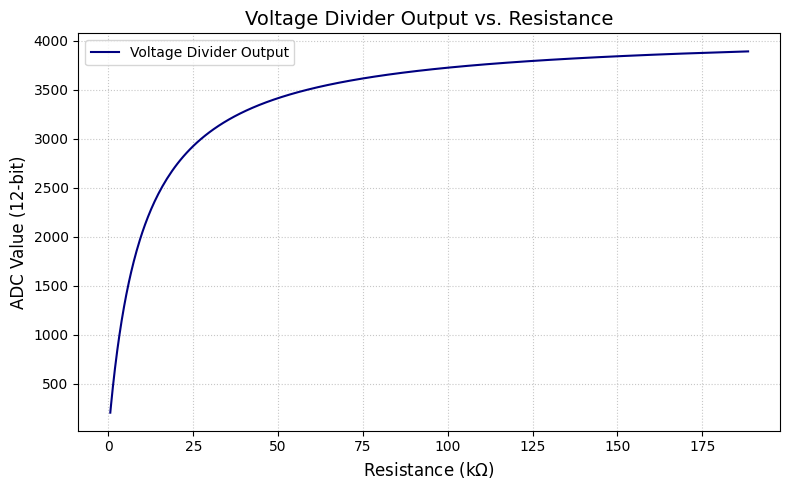

In [7]:
# Calculate values
resistances = df["Nom"] * 1e3  # Ohms
adc_values = (2**12) * resistances / (10e3 + resistances)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(resistances / 1e3, adc_values, label='Voltage Divider Output', color='navy')

# Labels and Title
plt.xlabel("Resistance (k$\Omega$)", fontsize=12)
plt.ylabel("ADC Value (12-bit)", fontsize=12)
plt.title("Voltage Divider Output vs. Resistance", fontsize=14)

# Grid, ticks, and legend
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.savefig("ADC-Reading-Thermistor-Divider.svg")
plt.show()


In [8]:
def calc_adc_from_ohms(r_therm, r_div = 10e3, nbits = 12):
    '''
    If the ADC is reference to ground and the voltage divider is off the same supply then we're ratiometric and can ignore the voltage.
    '''
    return r_therm/(r_therm + r_div)*(1<<nbits)

def calc_ohms_from_adc(adc, r_div = 10e3, nbits = 12):
    '''
    If the ADC is reference to ground and the voltage divider is off the same supply then we're ratiometric and can ignore the voltage.
    '''
    return adc/(1<<nbits)*(r_div)/(1-adc/(1<<nbits))

In [9]:
'''
even spacing in temp
'''
def calc_adc_from_temp(temp, thermistor: Thermistor, r_div = 10e3, nbits = 12):
    '''
    If the ADC is reference to ground and the voltage divider is off the same supply then we're ratiometric and can ignore the voltage.
    '''
    r_therm = thermistor.kelvin_to_resistance(temp)
 
    lsbs = (1<<nbits)*r_therm/(r_therm+r_div)
    return lsbs

def calc_temp_from_adc(adc, thermistor: Thermistor, r_div = 10e3, nbits = 12):
    '''
    If the ADC is reference to ground and the voltage divider is off the same supply then we're ratiometric and can ignore the voltage.
    '''
    res = adc/(1<<nbits)*(r_div)/(1-adc/(1<<nbits))
    return thermistor.resistance_to_kelvin(res)
    
const_adc_spacing = np.asarray([pt*32 + 8 for pt in range(0,128)])
temps_adc_spacing = [family(calc_temp_from_adc(pt, thermistor=therm_sh)) for pt in const_adc_spacing]

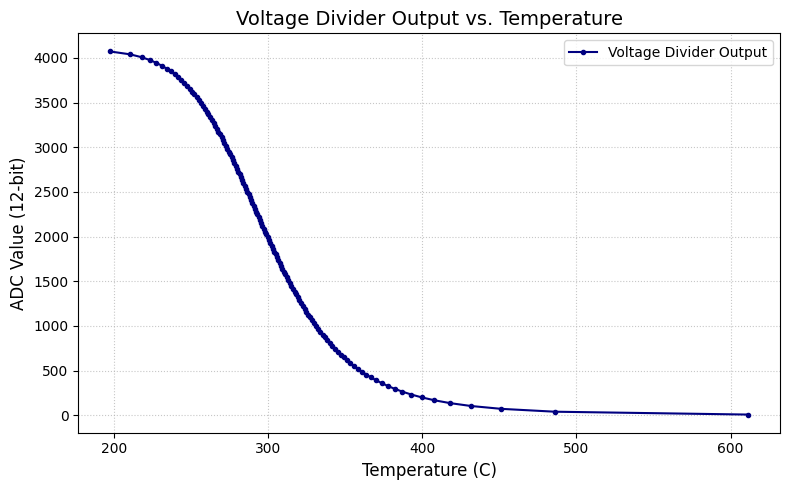

In [10]:
# Plot
plt.figure(figsize=(8, 5))
#plt.plot(temps, adc_values, '.-', label='Voltage Divider Output', color='navy')
plt.plot(temps_adc_spacing, const_adc_spacing, '.-', label='Voltage Divider Output', color='navy')

# Labels and Title
plt.xlabel("Temperature (C)", fontsize=12)
plt.ylabel("ADC Value (12-bit)", fontsize=12)
plt.title("Voltage Divider Output vs. Temperature", fontsize=14)

# Grid, ticks, and legend
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.savefig("ADC-Temperature.svg")
plt.show()

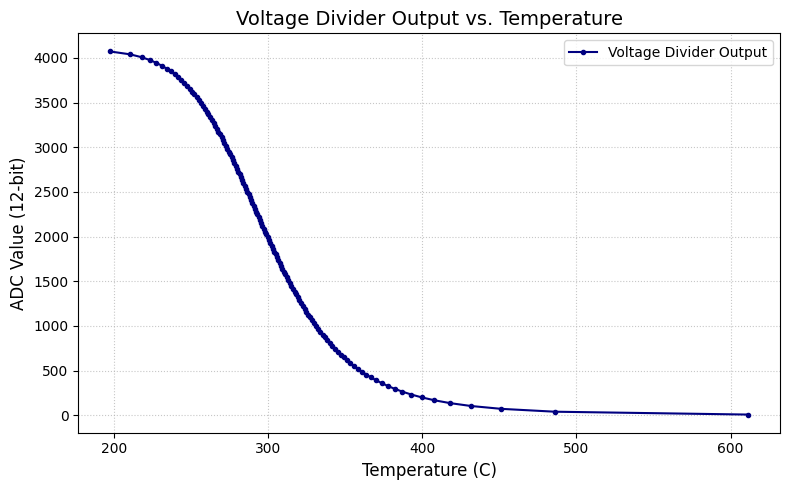

In [11]:
# Plot
plt.figure(figsize=(8, 5))
#plt.plot(temps, adc_values, '.-', label='Voltage Divider Output', color='navy')
plt.plot(temps_adc_spacing, const_adc_spacing, '.-', label='Voltage Divider Output', color='navy')

# Labels and Title
plt.xlabel("Temperature (C)", fontsize=12)
plt.ylabel("ADC Value (12-bit)", fontsize=12)
plt.title("Voltage Divider Output vs. Temperature", fontsize=14)

# Grid, ticks, and legend
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.savefig("ADC-Temperature.svg")
plt.show()